# Lecture 6
## The spatial coalescent/simulating whole genomes

## The spatial algorithm
So far we have thought about the coalescent tree/ARG as running backwards in time. Now we are going to introduce an important alternative perspective due to Wiuf and Hein (1999), which lets us generate ARGs from left to right, as we move along the chromosome.

Note: this algorithm might seem rather hard to understand at first. See GVE §5.5.2 for an intuitive explanation.

The algorithm works as follows. Suppose that we are shown the following ARG (Durrett p.102):

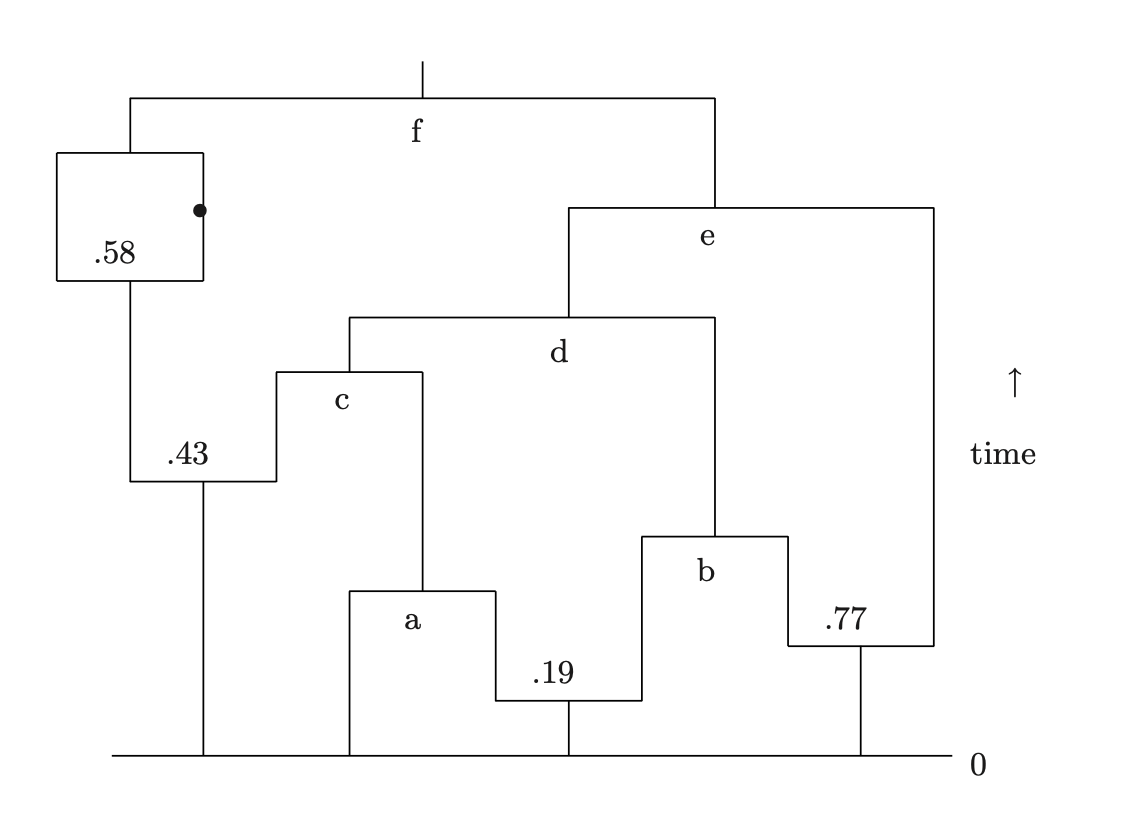

The genealogy for positions $[0,.19)$ is given by following each recombination event leftwards:

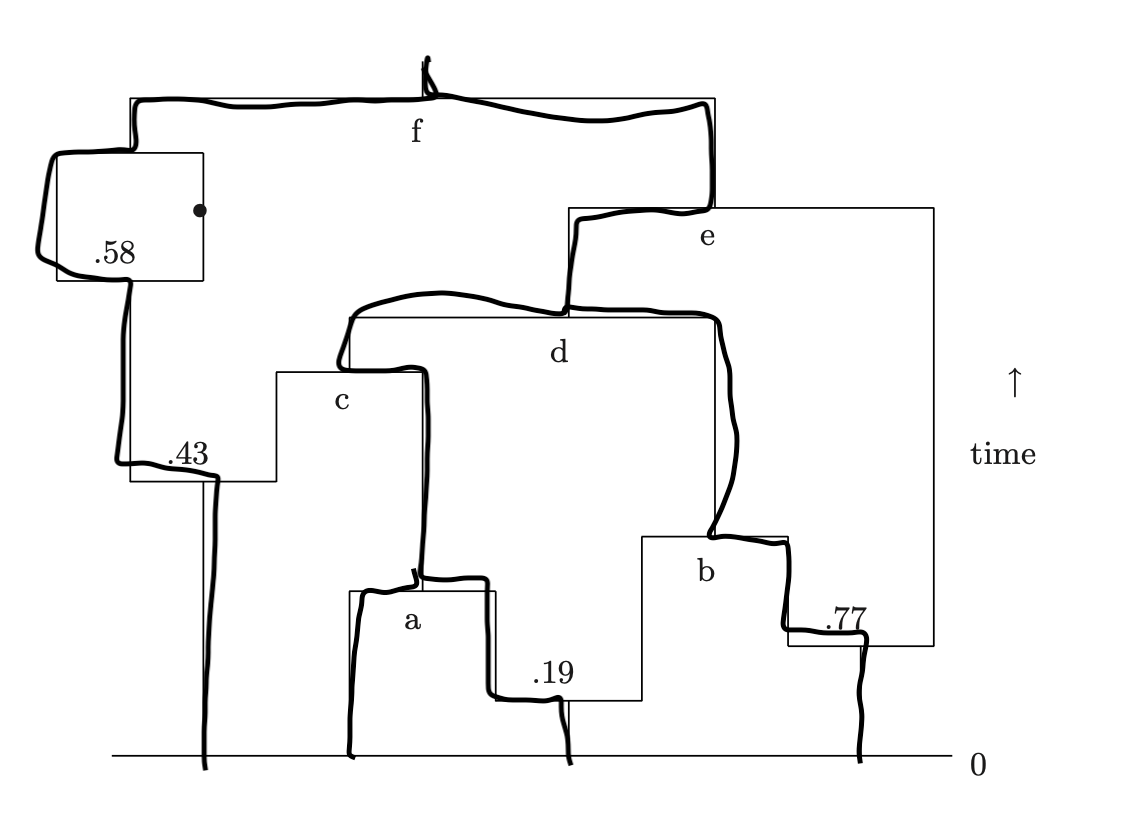

Conditional on this tree, what is the distribution of the location of the first recombination breakpoint (in this case, 0.19)?

Let the total branch length in the entire tree be $2Nb$ generations. The number of recombinations $n$ that occurs in these sequences is binomially distributed: 
$$p(n) \sim \operatorname{Binom}(n;2NbL,r),$$
where $r\ll1$ is the probability of a recombination at each position per generation.

Now, we will assume that $N\to\infty$ and $L\to\infty$, which $r\to 0$, such that $\lim 4NLr = \rho$. (These are reasonable asymptotics given the biological interpretation of the parameters.) Then $$p(n) \sim \operatorname{Poisson}(n;b\rho/2).$$

In particular, the probability of no recombination is $e^{-b\rho/2}$, and the distribution of the first recombination breakpoint $X$ is $\mathbb{P}(X>x\mid b)=e^{-bx}$.